In [1]:
import theano
from theano import pp
import theano.tensor as tt
from dataclasses import dataclass

import glob
import time 
import pymc3 as pm 
import numpy as np
import arviz as az
import xarray as xr
import scipy.stats as st
import matplotlib.pyplot as plt 

In [2]:
Young2020 = xr.open_dataset("../MB_tune/notebooks/Young_etal_2020_Delta_T_-0.9_C.nc")
z_ref  = Young2020.stack(z=('x', 'y')).Elevation.mean().values
A_mean = Young2020.stack(z=('x', 'y')).Accumulation.mean().values

In [3]:
def air_temp(z): 
    doy = np.arange(1,366)[:, np.newaxis]

    α     = 10.5   # [C]
    T_ma  = -6.65  # [C]
    ΔTΔz  = 6.5E-3 # [K m^-1]
    T_p   = 196    # [doy]
    ref_z = 2193   # [m]

    return α*np.cos( 2*np.pi*(doy-T_p)/365 )+ΔTΔz*(ref_z-z)+T_ma
    
def tt_melt_model(z, f_snow, C, grad_A, f_r): 
    T_m    = 0.0
    T_rs   = 1.0
    A_mean = 1.4 * 910. 
    ref_z  = 2193
    
    f_ice = C*f_snow
    T     = air_temp(z) #+ T_bias
    
    PDDs = tt.switch(tt.gt(T, T_m), T, 0.0).sum(axis=0) 

    accum_days = tt.switch(tt.lt(T, T_rs), 1/365., 0.0).sum(axis=0)  

    # calculate snow accumulation
    A_snow = tt.maximum((accum_days*A_mean)*
                      (1+(z-ref_z)*grad_A), 0.0)
    
    # calculate local surface melt assuming f_m = f_snow
    melt_local = PDDs * f_snow
    
    # calculate refreezing
    R = tt.minimum(f_r*A_snow, melt_local)
    
    
    r_s2m = tt.switch(tt.eq(melt_local, 0.0), 1.0, A_snow/melt_local)
    
    f_m = tt.switch(tt.ge(r_s2m, 1.), f_snow,
                    f_ice - (f_ice - f_snow)*r_s2m)
    
    # calculate surface melt [kg m^{-2} yr^{-1}] with f_m
    M_melt = f_m*PDDs
    
    return (A_snow + R - M_melt) * (1/910)


def np_melt_model(z, f_snow, C, grad_A, f_r): 
    T_m    = 0.0
    T_rs   = 1.0
    A_mean = 1.4 * 910. 
    ref_z  = 2193
    
    f_ice = C*f_snow
    T     = air_temp(z) #+ T_bias
    
    PDDs = np.where(T>T_m,  T-T_m, 0).sum(axis=0)
    accum_days = np.where(T<T_rs, 1/365., 0.0).sum(axis=0)  

    # calculate snow accumulation
    A_snow = np.maximum((accum_days*A_mean)*
                      (1+(z-ref_z)*grad_A), 0.0)    
    
    # calculate local surface melt assuming f_m = f_snow
    melt_local = PDDs * f_snow
    
    # calculate refreezing
    R = np.minimum(f_r*A_snow, melt_local)
    
    # compute the ratio b/w accumulated snow and total melt assuming f_m = f_snow
    with np.errstate(divide='ignore', invalid='ignore'):
        r_s2m = np.where(melt_local==0.0, 1.0, A_snow / melt_local)
    
    # Compute nodal specific degree day factor
    f_m = np.where(r_s2m >= 1, f_snow,
                   f_ice - (f_ice - f_snow)*r_s2m)
        
    # calculate surface melt [kg m^{-2} yr^{-1}] with f_m
    M_melt = f_m*PDDs
    
    return (A_snow + R - M_melt) * (1/910)

In [4]:
with xr.open_dataset('../../initialization/coarse/result/crmpt18-a/nc/crmpt18-a_1000a_dt_1_dx_100_MB_00.2_OFF.nc') as src: 
    # correct for minimum ice thickness
    src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
    # apply sigma coordinate transform for vertical coordinate
    src["Z"]     = src.zbed + src.Z * src.height 
    # Calculate the magnitude of the velocity vectors
    src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)    

In [5]:
mask = src.height.isel(t=-1,coord_2=-1).values > 10.
z  = src['zs'].isel(t=-1,coord_2=-1).values[np.newaxis, :]
MB = np.random.normal(src['zs accumulation flux 2'].isel(t=-1,coord_2=-1).values, 1e-1)[np.newaxis, :]

In [6]:
# Define Priors
with pm.Model() as model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_prior  = pm.TruncatedNormal("f_s",    mu=4.1,  sigma=0.5,  lower=0.0)
    # Somewhat base of Aschwanden et al. 2019
    C_prior    = pm.TruncatedNormal("C",      mu=2.0,  sigma=1.5,  lower=1)
    # Need a reference for the accumulation grad distibution 
    grad_a     = pm.Uniform("grad_a", lower=1e-4, upper=1e-2)
    # Somewhat base of Aschwanden et al. 2019
    f_r_prior  = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.5,  lower=0.0, upper=1)
    # Temp bias
    # T_b_prior  = pm.Uniform("T_b", lower=0, upper=4)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # We should probably account for the error associated with our 
    # mass balance model not able to actually fit the Young et al. results
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ????? 
    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10)    


# Define Forward model (wrapped through theano)
with model: 
    melt, _ = theano.scan(fn=tt_melt_model, 
                sequences = [z],
                outputs_info = None, 
                non_sequences= [f_s_prior, C_prior, grad_a, f_r_prior])
    

# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=melt, sigma=sigma, observed=MB)
    
# run inference: Sample   
with model: 

    # obtain starting values via MAP
    startvals = pm.find_MAP()
    
    trace = pm.sample(start=startvals,
                      draws=2000, 
                      tune=1000, 
                      cores=2, 
                      return_inferencedata=True,
                      target_accept=0.95);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, f_r, grad_a, C, f_s]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 103 seconds.


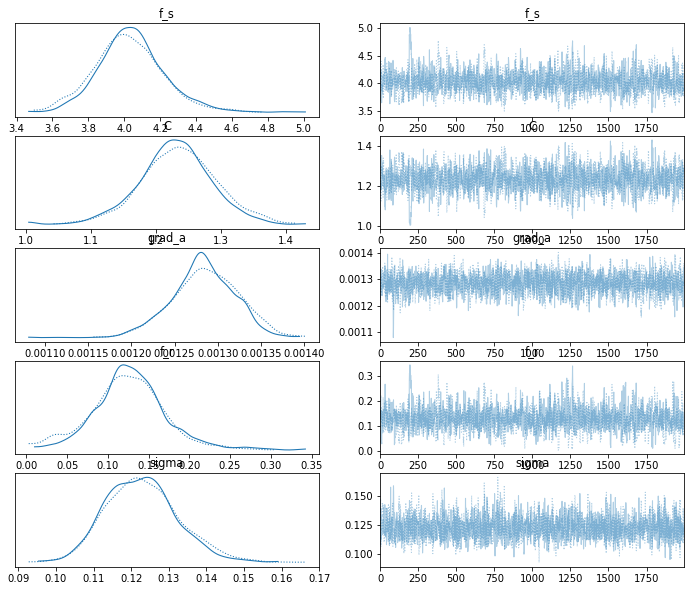

In [7]:
az.plot_trace(trace );

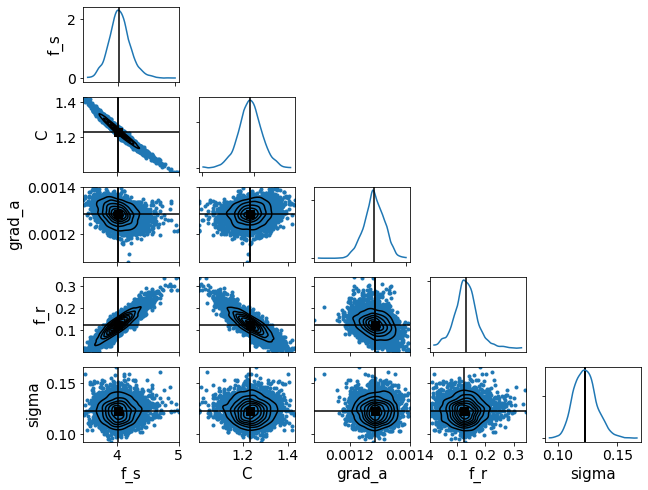

In [8]:
ax = az.plot_pair(
    trace,
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="median",
    figsize=(10, 8),
)

In [9]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f_s,4.035,0.194,3.643,4.384,0.006,0.004,1238.0,1212.0,1.00
C,1.233,0.059,1.114,1.342,0.002,0.001,1301.0,1206.0,1.00
grad_a,0.001,0.000,0.001,0.001,0.000,0.000,1960.0,1824.0,1.00
f_r,0.126,0.045,0.033,0.211,0.001,0.001,1180.0,881.0,1.01
sigma,0.123,0.010,0.105,0.141,0.000,0.000,2250.0,2249.0,1.00


In [10]:
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["f_s", "C", "grad_a", "f_r", "sigma", "Y_obs"])

post_samples = np.stack([ppc[key] for key in list(ppc)[:-1]])

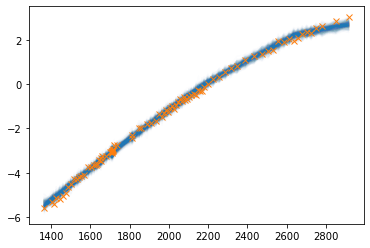

In [11]:
for i in np.random.randint(0,3999,499):
    
    params    = post_samples[:,i]
    
#     plt.plot(z[0], 
#              np.random.normal(np_melt_model(z, *params[:-1])[0], params[-1]),
#              c='tab:blue', 
#              alpha=0.01)

    plt.plot(z[0], ppc['Y_obs'][i,0], c='tab:blue', alpha=0.01)
    
    
plt.plot(z[0], MB[0], 'x', c='tab:orange')

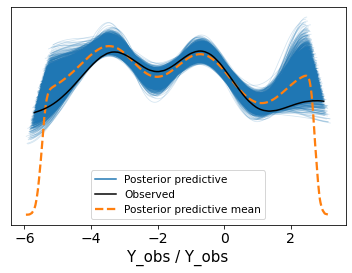

In [60]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));